# IOPS Test Report

## Experiment Environment

<table>
  <tr>
    <th colspan="2"><b>Set Up Parameters</b></th>
  </tr>
  <tr>
    <td><b>Active Range</b></td>
    <td>75%<br></td>
  </tr>
  <tr>
    <td><b>Pre Condition 1</b></td>
    <td>SEQ 128KB W</td>
  </tr>
  <tr>
    <td>    TOIO - TC/QD</td>
    <td>TC 2 / QD 16</td>
  </tr>
  <tr>
    <td>    Duration</td>
    <td>2 x User Capacity</td>
  </tr>
  <tr>
    <td><b>Purge Method</b></td>
    <td>None</td>
  </tr>
  <tr>
    <td><b>Write Cache</b></td>
    <td>Enabled</td>
  </tr>
</table>


<table>
  <tr>
    <th colspan="2"><b>Test Parameters</b></th>
  </tr>
  <tr>
    <td><b>Active Range</b></td>
    <td>75%</td>
  </tr>
  <tr>
    <td><b>Test Stimulus 1</b></td>
    <td>SEQ</td>
  </tr>
  <tr>
    <td>    Block Size (Outer Loop)</td>
    <td>1024KB, 128KB, 64KB, 32KB, 16KB, 8KB, 4KB, 512B</td>
  </tr>
  <tr>
    <td>    R/W Mix (Inner Loop)</td>
    <td>100/0, 95/5, 65/35, 50/50, 35/65, 5/95, 0/100</td>
  </tr>
  <tr>
    <td>    TOIO - TC/QD</td>
    <td>TC 2 / QD 16</td>
  </tr>
</table>

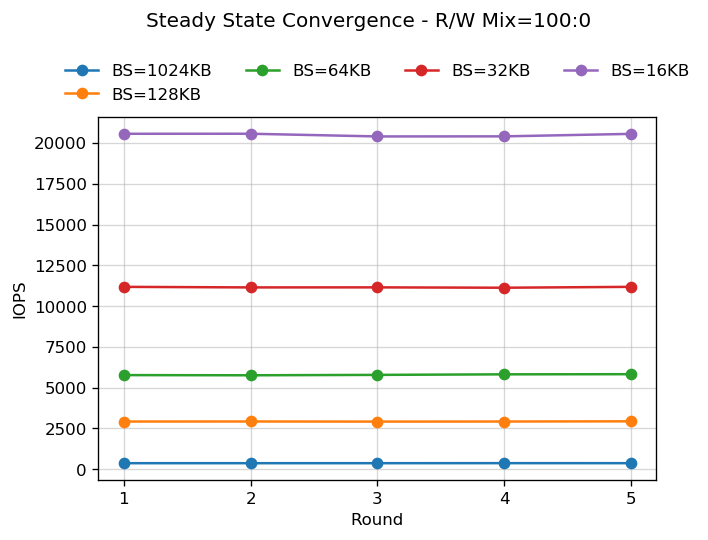

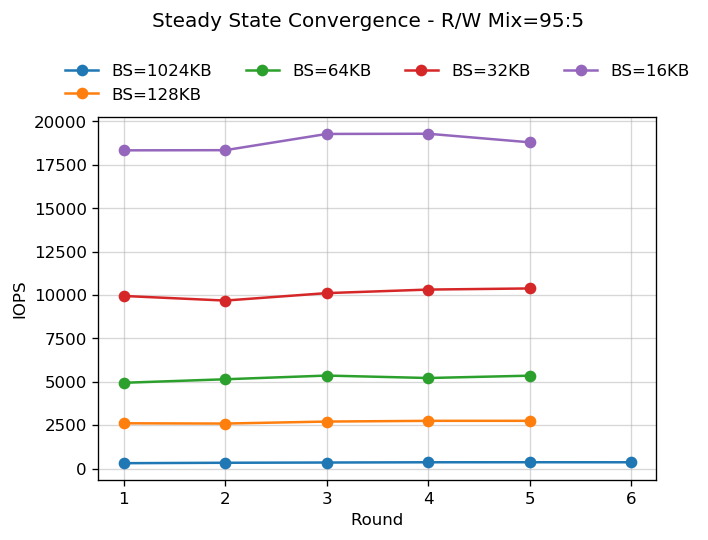

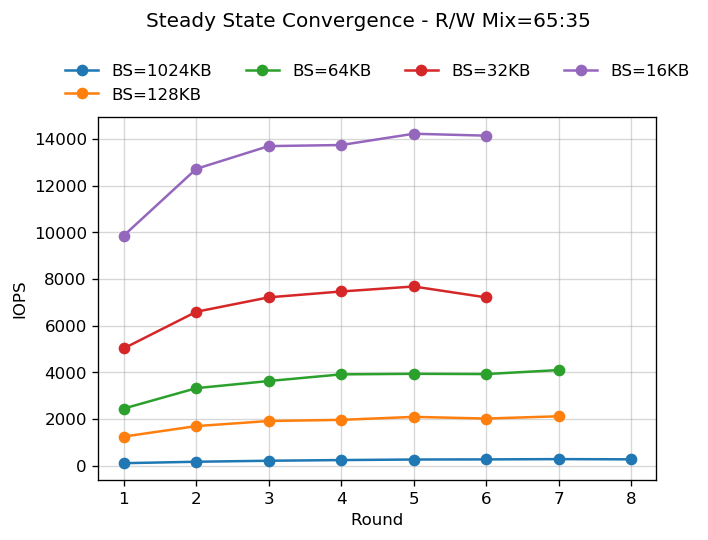

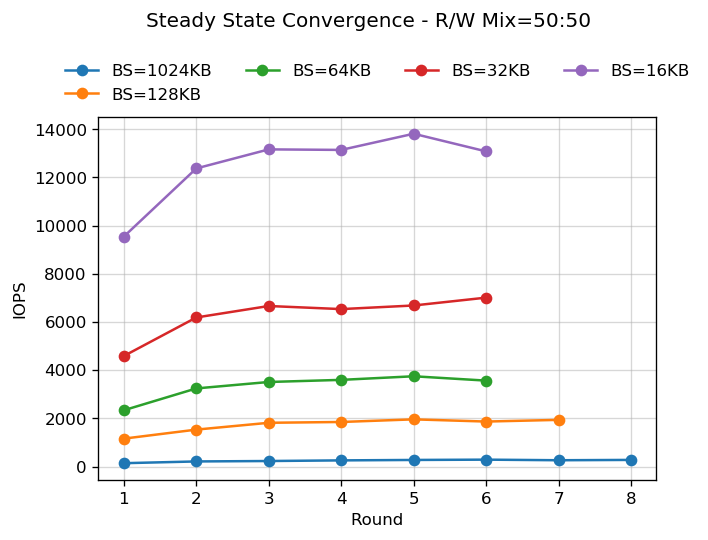

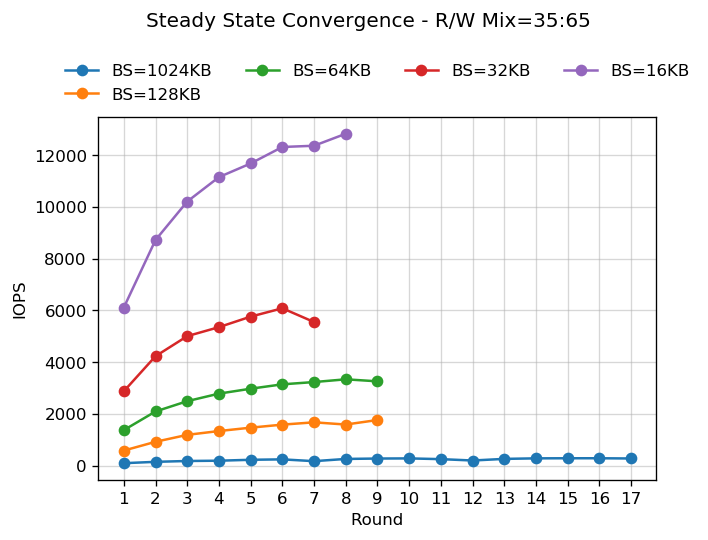

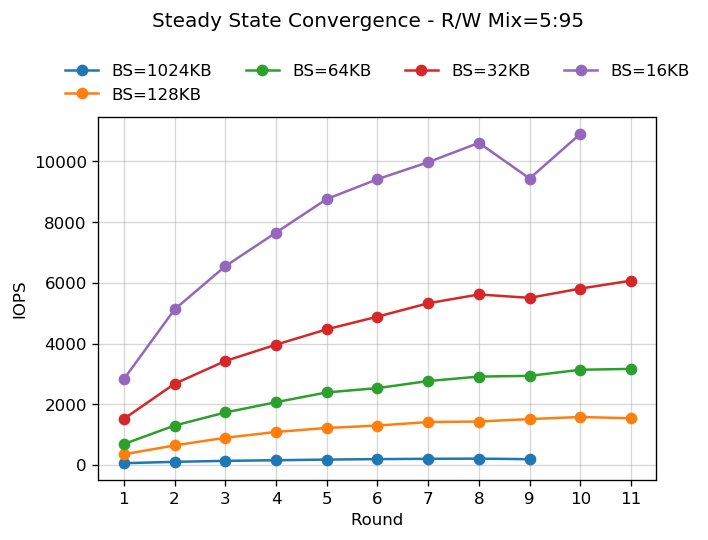

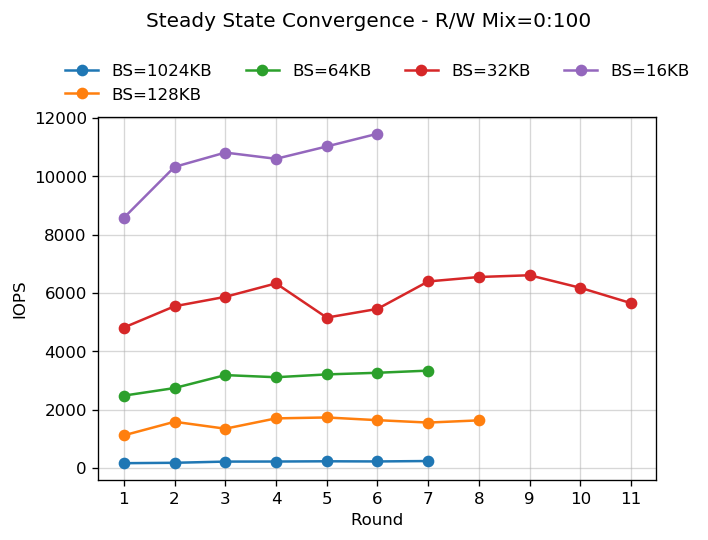

In [2]:
from common import util
from IPython.display import display, Markdown, HTML

import matplotlib.pyplot as plt
import numpy as np


# BLOCK_SIZES = ['1024KB', '128KB', '64KB', '32KB', '16KB', '8KB', '4KB', '512B']
BLOCK_SIZES = ['1024KB', '128KB', '64KB', '32KB', '16KB']
RWMIXREADS = [100, 95, 65, 50, 35, 5, 0]


def __get_avg_iops(profiles_dirname, bs, rwmixread):
    """Get all average IOPS in profiles matching the block size and rwmixread.
    
    Args:
        profiles_dirname (str): The name of the profile folder.
        bs (str): The block size.
        rwmixread (int): The percentage of read in read/write mix I/O.
    
    """
    rounds = []
    values = []
    
    round_profile_pairs = util.get_profiles(profiles_dirname, bs, rwmixread)
    for rp in round_profile_pairs:
        rounds.append(rp[0])
        profile = rp[1]
        
        runtime = util.get_num_in(profile, ['read', 'runtime'])
        if runtime == 0:
            runtime = util.get_num_in(profile, ['write', 'runtime'])
        runtime_in_seconds = runtime / 1000
        
        total_iops = util.get_num_in(profile, ['read', 'total_ios']) + \
                        util.get_num_in(profile, ['write', 'total_ios'])
        
        values.append(total_iops / runtime_in_seconds)
        
    return rounds, values


def plot_ss_convergence(profiles_dirname):
    for rwmixread in RWMIXREADS:
        fig, ax = plt.subplots()

        # Change the size of figure
        # See https://stackoverflow.com/a/4306340
        fig.set_dpi(util.FIG_DPI)

        max_round = 1
        bars = []
        for bs in BLOCK_SIZES:
            rounds, values = __get_avg_iops(profiles_dirname, bs, rwmixread)
            bars.append(ax.errorbar(rounds, values, fmt='-o'))
        
            max_round = max(rounds[-1], max_round)
        
        ax.set_xticks(range(1, max_round + 1))
        ax.grid(which='major', alpha=0.5)
        ax.set_ylabel('IOPS')
        ax.set_xlabel('Round')

        plt.legend(
                bars,
                ['BS=' + bs for bs in BLOCK_SIZES],
                loc=8,
                bbox_to_anchor=(0.5, 1),
                frameon=False,
                ncol=4)
        plt.suptitle(
            'Steady State Convergence - R/W Mix=' + \
            str(rwmixread) + ':' + str(100 - rwmixread),
            y=1.1)
        plt.show()
    

profiles_dirname = '192.168.140.138/output_iops'

plot_ss_convergence(profiles_dirname)

## Notes

### Definition of ***Steady State***

```
A device is said to be in Steady State when, for the dependent variable (y)
being tracked:
    a) Range(y) is less than 10% of Ave(y): Max(y)-Min(y) within the
       Measurement Window is no more than 10% of the Ave(y) within the
       Measurement Window; and
    b) Slope(y) is less than 10%: Max(y)-Min(y), where Max(y) and Min(y) are
       the maximum and minimum values on the best linear curve fit of the
       y-values within the Measurement Window, is within 10% of Ave(y) value
       within the Measurement Window.
```

## References

- [Solid State Storage (SSS) Performance Test Specification (PTS) v2.0.1](https://www.snia.org/sites/default/files/technical_work/PTS/SSS_PTS_2.0.1.pdf)